<a href="https://colab.research.google.com/github/jh226/2024-SW-AI/blob/main/%EC%A3%BC%EC%B0%A8%EC%9E%90%EB%A6%AC%ED%83%90%EC%A7%80%EB%AA%A8%EB%8D%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#주차공간 탐지 모델 만들기
##용도
    1. 공용 주차 공간의 빈자리를 탐지
    2. 주차 공간 안내에 활용이 가능함.
    3. 기존의 센서 방식은 설치 비용이 과다함
    4. 고장등의 이유로 오 동작 하는 경우가 많음
    


## YOLO 클로닝

In [ ]:
# 현재 폴더
%pwd
# 위치 이동을 강제로 해야 한다면
%cd /content/
%pwd

In [ ]:
# github에서 YOLO 가져오기 https://github.com/ultralytics/yolov5
!git clone https://github.com/ultralytics/yolov5

In [ ]:
!pip list


### 학습 1번째 실행할때 나오는 에러
1. colab은 대부분의 패키지가 설치 된것으로 알고 있음
2. 그래서 Traceback (most recent call last):
  File "/content/yolov5/train.py", line 848, in <module>
    main(opt)
  File "/content/yolov5/train.py", line 623, in main
    train(opt.hyp, opt, device, callbacks)
  File "/content/yolov5/train.py", line 254, in train
    train_loader, dataset = create_dataloader(
  File "/content/yolov5/utils/dataloaders.py", line 181, in create_dataloader
    dataset = LoadImagesAndLabels(
  File "/content/yolov5/utils/dataloaders.py", line 604, in __init__
    assert nf > 0 or not augment, f"{prefix}No labels found in {cache_path}, can not start training. {HELP_URL}"
AssertionError: train: No labels found in /content/yolov5/pklot/train/labels.cache, can not start training. See https://docs.ultralytics.com/yolov5/tutorials/train_custom_data 이런 애러에 대한 대비를 안함
3. 이것을 방지 하기 위해서 또는 내 PC에서 작업 해야 하는 경우에 반드시 패키지 설치를 해야 함.
4. 그러기 위해서 PC 의 경우 가상환경 만들고
5. pip install -r requirements.txt 를 했어야 한다.


In [ ]:
%cd /content/yolov5


In [ ]:
!pip install -r requirements.txt


## 데이터 다운로드를 위한 작업 폴더 생성 및  이동

In [ ]:
%cd /content/yolov5
%mkdir pklot
%cd pklot

In [ ]:
%cd /content/yolov5/pklot


## dataSet를 가져 오기
주차공간 데이터셋: https://public.roboflow.com/object-detection/pklot

1. 위 링크를 클릭해서 따라 가세요
2. 데이터 세트는 public.roboflow.com에 여러가지가 있고
3. 최근에는 universe에 각각의 모델과 데이터세트가 함게 존재 함

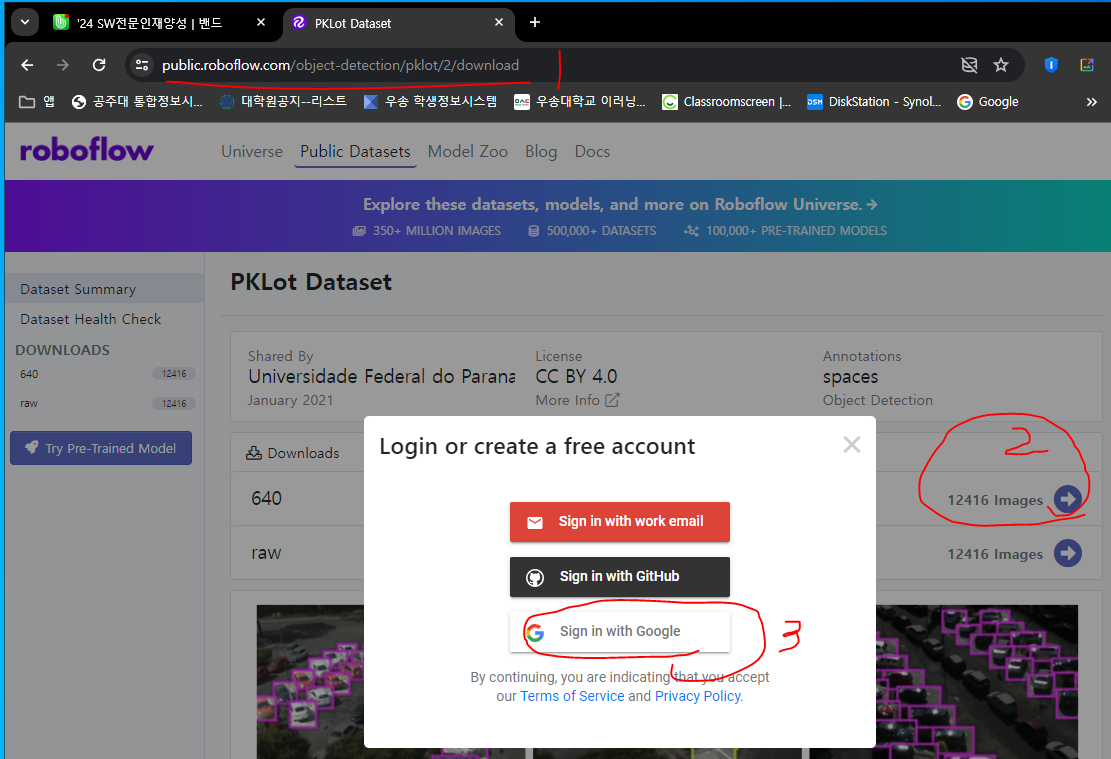

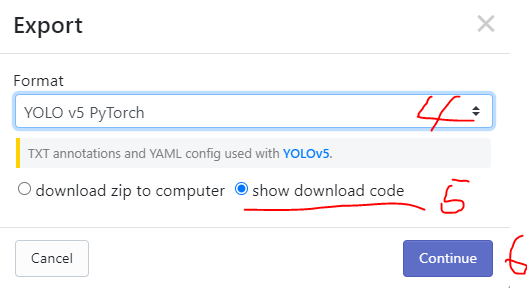

4. 해당 url을 복사 합니다.
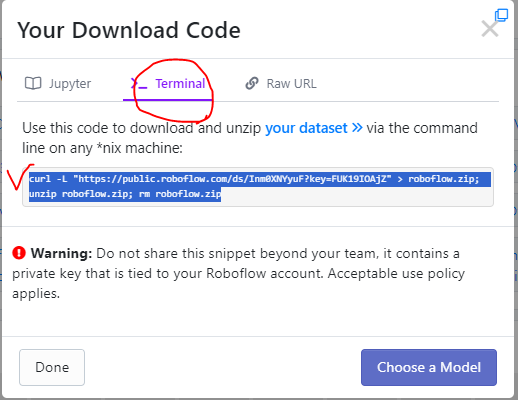

복사한 URL을 실행해서 데이터 세트를 다운로드 받습니다.

In [ ]:
!curl -L "https://public.roboflow.com/ds/Inm0XNYyuF?key=FUK19IOAjZ" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

### 참고 사항

%와 !는 Colab에서 사용되는 두 가지 다른 종류의 명령어입니다.


! (셀 명령어):
이 명령어는 셀 내에서 셸 명령을 실행하는 데 사용됩니다. 주어진 셸 명령을 실행하고 결과를 출력합니다.

% (매직 명령어):
이 명령어는 셀 매직 명령어를 나타내며, 주피터 노트북 환경에서 특별한 기능을 제공합니다. 예를 들어, %matplotlib inline은 그래프를 인라인으로 표시하도록 지시하는데 사용됩니다. 다른 예로 %timeit은 코드 실행 시간을 측정하는 데 사용됩니다.

## dataSet의 구성 내용을 확인

In [ ]:
from glob import glob
train_img_list = glob('/content/yolov5/pklot/train/images/*.jpg')
test_img_list = glob('/content/yolov5/pklot/test/images/*.jpg')
valid_img_list = glob('/content/yolov5/pklot/valid/images/*.jpg')
print(len(train_img_list), len(test_img_list), len(valid_img_list))

## 모델 FineTunning을 시작

## 1. 데이터세트의 위치등을 알려주기 위한 yaml 파일 준비

In [ ]:
import yaml
with open('/content/yolov5/pklot/train.txt','w') as f:
    f.write('\n'.join(train_img_list) + '\n')
with open('/content/yolov5/pklot/test.txt','w') as f:
    f.write('\n'.join(test_img_list) + '\n')
with open('/content/yolov5/pklot/val.txt','w') as f:
    f.write('\n'.join(valid_img_list) + '\n')

### fineTunning중에 자주 사용하는 writetemplate 함수를 정의한다.

In [ ]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line,cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [ ]:
%cat data.yaml

1. 이번에는 데이터 세트를 보면 nc가 2개이고
각각의 class의 이름은 space-empty와 space-cooupied로 되어 있음을 알수 있다.
2. 또한 test 데이터에 대한 정보가 없다.
    . 학습을 위해서 꼭 필요한 train. val 데이터에 대한 정보만 있음


### FineTunning중에 모델에게 dataSet의 위치를 알려 주기 위한 data.yaml을 만든다

1. 기존에 있던 내용을 수정해서 위치만 수정

In [ ]:
%%writetemplate /content/yolov5/pklot/data.yaml

train: /content/yolov5/pklot/train/images
val: ./pklot/valid/images

nc: 2
names: ['space-empty', 'space-occupied']

수정된 data.yaml을 다시 한번 확인

In [ ]:
%cat /content/yolov5/pklot/data.yaml

### 만들어진 data.yaml에서 필요한 변수(nc)를 가져오기

In [ ]:
with open('/content/yolov5/pklot/data.yaml','r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])
  print (num_classes)

### custom_yolov5s.yaml을 만들기    
    1. 원래 pre-trained된yolov5s.yaml이 갖고 있는 내용을 수정해서 만들어야 함.
        -. 원본 yolov5s.yaml을 cat으로 프린트 해서
        -. 복사한여 사용한다.
    2. 원래 있던 yaml 내용중 ,nc 부분만 수정해 준다.

In [ ]:
%cat /content/yolov5/models/yolov5s.yaml
# 실행후 nc : 80 인것을 위에서 가져온 num_classes로 바꿔 주도록 한다.

### custom_yolov5s.yaml 파일을 만든다.

In [ ]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

### 최종 만들어진 custom_yolov5s.yaml의 내용중 nc가 수정되었는지 확인
nc = num_classes = 2

In [ ]:
%cat /content/yolov5/models/custom_yolov5s.yaml

## 2. 학습 시작

### 학습을 위해서 폴더 이동하고 시간 기록하기

In [ ]:
import time
%cd /content/yolov5/
%time

### train.py에 파라메타 전달하고 실행하기

In [ ]:
!python train.py --img 640 --batch 16 --epochs 100 --data ./pklot/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name pklot_result  --cache